In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
import gc # Garbage collector

# --- Configuration ---
N_LAGS = 21 # Number of past time steps for sequence input (increased)
N_LEADS = 6 # Predict 6 days ahead (+ current day view)
N_ROLLING_WINDOWS = [7, 14, 28] # Rolling window sizes for context features
SPLIT_DATE = '2016-06-01'
DO_LOG_TRANSFORM = True # Apply log1p transform to Views
SCALE_TARGETS = True # Scale the target variables
SCALE_CONTEXT = True # Scale the context features

# Load the data
data = pd.read_csv('train_1.csv')
print("Original data shape:", data.shape)

# --- Initial Page Parsing ---
mask = data['Page'].str.split('_').apply(lambda x: len(x) != 4)
problem_rows = data[mask]
if not problem_rows.empty:
    print("Warning: Rows with unexpected Page format found.")

pattern = r'^(?P<Title>.+)_(?P<Project>[^_]+)_(?P<Access>[^_]+)_(?P<Agent>[^_]+)$'
data[['Title', 'Project', 'Access', 'Agent']] = data['Page'].str.extract(pattern, expand=False)

problem_rows = data[data[['Title', 'Project', 'Access', 'Agent']].isnull().any(axis=1)]
if not problem_rows.empty:
   print("Problem rows after regex extraction:")
   print(problem_rows[['Page']].head())

data = data.drop(columns=['Title'])
data['Title'] = data['Page']
data = data.drop(columns=['Page'])
data.drop(['Access', 'Agent', 'Title'], axis=1, inplace=True)

# --- Project Feature Engineering ---
data['CountryCode'] = data['Project'].str.extract(r'^(.*?)\.wikipedia\.org$', expand=False)
# Use assignment instead of inplace=True on fillna
data['CountryCode'] = data['CountryCode'].fillna('unknown')
data['Project_numeric'] = pd.factorize(data['CountryCode'])[0] + 1
data.drop(columns=['CountryCode', 'Project'], inplace=True)

# --- Aggregation by Project ---
date_columns = data.columns[data.columns.str.match(r'\d{4}-\d{2}-\d{2}')]
df_merged = data.groupby('Project_numeric')[date_columns].sum().reset_index()
print("Grouped data shape:", df_merged.shape)
gc.collect() # Clean up memory

# --- Feature Engineering (Sequence = Lags, Context = Current Features) ---
print("Starting Feature Engineering...")
# Melt the dataframe
date_columns_list = df_merged.columns[df_merged.columns.str.match(r'\d{4}-\d{2}-\d{2}')].tolist()
df_long = df_merged.melt(id_vars=['Project_numeric'],
                         value_vars=date_columns_list,
                         var_name='Date',
                         value_name='Views')
del df_merged # Free memory
gc.collect()

df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['Views'] = pd.to_numeric(df_long['Views'], errors='coerce')
# Use assignment instead of inplace=True on fillna
df_long['Views'] = df_long['Views'].fillna(0)
df_long.sort_values(by=['Project_numeric', 'Date'], inplace=True)
df_long.reset_index(drop=True, inplace=True)

# --- Log Transform (Optional but Recommended) ---
if DO_LOG_TRANSFORM:
    df_long['LogViews'] = np.log1p(df_long['Views'])
    print("Applied log1p transformation to Views.")
    value_col = 'LogViews'
else:
    value_col = 'Views'

# --- Create Lag Features (for LSTM Sequence Input) ---
# Optimized approach to avoid fragmentation
print(f"Creating {N_LAGS} lag features for '{value_col}'...")
lag_data = {}
for i in range(1, N_LAGS + 1):
    lag_data[f'lag{i}'] = df_long.groupby('Project_numeric')[value_col].shift(i)
lag_df = pd.DataFrame(lag_data)
sequence_features = [f'lag{i}' for i in range(N_LAGS, 0, -1)] # Order: lagN -> lag1

# --- Create Lead Features (Targets) ---
# Optimized approach
print(f"Creating {N_LEADS} lead features (targets)...")
lead_data = {}
target_features = [value_col] # Include current value as first target
for i in range(1, N_LEADS + 1):
    lead_col_name = f'lead{i}'
    lead_data[lead_col_name] = df_long.groupby('Project_numeric')[value_col].shift(-i)
    target_features.append(lead_col_name)
lead_df = pd.DataFrame(lead_data)

# --- Create CURRENT Context Features ---
print("Creating current context features...")
# Date Features (Current)
df_long['dayofweek'] = df_long['Date'].dt.dayofweek
df_long['month'] = df_long['Date'].dt.month
df_long['dayofyear'] = df_long['Date'].dt.dayofyear
# df_long['year'] = df_long['Date'].dt.year # Optional

# Cyclical Date Features (Current)
df_long['dayofweek_sin'] = np.sin(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['dayofweek_cos'] = np.cos(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['month_sin'] = np.sin(2 * np.pi * df_long['month'] / 12.0)
df_long['month_cos'] = np.cos(2 * np.pi * df_long['month'] / 12.0)
df_long['dayofyear_sin'] = np.sin(2 * np.pi * df_long['dayofyear'] / 365.25)
df_long['dayofyear_cos'] = np.cos(2 * np.pi * df_long['dayofyear'] / 365.25)

# Rolling Window Features (Current context, using data PRIOR to current day)
# Optimized approach
rolling_data = {}
print(f"Creating rolling window features for windows: {N_ROLLING_WINDOWS}...")
grouped_data = df_long.groupby('Project_numeric')[value_col]
for window in N_ROLLING_WINDOWS:
    # Shift(1) ensures rolling window uses data PRIOR to the current day
    rolling_data[f'rolling_mean_{window}'] = grouped_data.shift(1).rolling(window=window, min_periods=1).mean()
    rolling_data[f'rolling_std_{window}'] = grouped_data.shift(1).rolling(window=window, min_periods=1).std()
rolling_df = pd.DataFrame(rolling_data)
# Fill NaNs in rolling std dev (can happen if window has only 1 point or constant values)
rolling_df.fillna(0, inplace=True) # Fill std=NaN with 0

# Define context features list
context_features = [
    'Project_numeric', # Keep as context
    'dayofweek_sin', 'dayofweek_cos',
    'month_sin', 'month_cos',
    'dayofyear_sin', 'dayofyear_cos',
    # 'year' # Optional
] + rolling_df.columns.tolist() # Add all rolling feature names

# --- Combine all features ---
print("Concatenating all features...")
# Select necessary original columns + add new ones
cols_to_keep = ['Project_numeric', 'Date', value_col] + \
               [f for f in context_features if f in df_long.columns] # Keep original context cols if they exist
df_final = pd.concat([df_long[cols_to_keep], lag_df, lead_df, rolling_df], axis=1)
del df_long, lag_df, lead_df, rolling_df # Free memory
gc.collect()

# --- Drop Rows with NaNs ---
print("Dropping rows with NaNs...")
initial_rows = df_final.shape[0]
# Check NaNs in lags, leads, and rolling features that require minimum periods
# Rolling mean should be fine with min_periods=1, lags require N_LAGS, leads require N_LEADS
cols_to_check_for_nan = sequence_features + target_features
df_final.dropna(subset=cols_to_check_for_nan, inplace=True)
print(f"Dropped {initial_rows - df_final.shape[0]} rows due to NaNs.")
print("Final DataFrame shape:", df_final.shape)

# --- Final Feature Lists ---
print(f"\nSequence Features ({len(sequence_features)}): {sequence_features}")
print(f"Context Features ({len(context_features)}): {context_features}")
print(f"Target Features ({len(target_features)}): {target_features}")

df_final = df_final.loc[:, ~df_final.columns.duplicated()]
# --- Split data ---
print(f"\nSplitting data at {SPLIT_DATE}...")
train_df = df_final[df_final['Date'] < SPLIT_DATE].copy()
test_df = df_final[df_final['Date'] >= SPLIT_DATE].copy()
print(f"Train df shape: {train_df.shape}")
print(f"Test df shape: {test_df.shape}")

# --- Scaling ---
print("Scaling features...")
# Scale sequence features (Lags of value_col)
scaler_seq = StandardScaler()
train_df[sequence_features] = scaler_seq.fit_transform(train_df[sequence_features])
test_df[sequence_features] = scaler_seq.transform(test_df[sequence_features])
print("Sequence features scaled.")

# Scale context features (Optional but recommended)
if SCALE_CONTEXT:
    scaler_context = StandardScaler()
    train_df[context_features] = scaler_context.fit_transform(train_df[context_features])
    test_df[context_features] = scaler_context.transform(test_df[context_features])
    print("Context features scaled.")
else:
    print("Context features were NOT scaled.")


# Scale target features (Optional)
if SCALE_TARGETS:
    scaler_target = StandardScaler()
    train_df[target_features] = scaler_target.fit_transform(train_df[target_features])
    test_df[target_features] = scaler_target.transform(test_df[target_features])
    print("Target features scaled.")
else:
    print("Target features were NOT scaled.")

TARGETS_SCALED = SCALE_TARGETS # Flag for inverse transform later
CONTEXT_SCALED = SCALE_CONTEXT

# --- Store Test Dates ---
print("Storing test dates...")
test_dates_list = test_df['Date'].tolist()
print(f"Stored {len(test_dates_list)} dates from the test set.")

# --- Clean up ---
print("Deleting final pandas DataFrame to free memory...")
del df_final # Keep train_df, test_df for tensor creation
gc.collect()
print("\n--- Data Preparation Cell Complete ---")
display(train_df.head())
display(test_df.head())

Original data shape: (145063, 551)
Grouped data shape: (8, 551)
Starting Feature Engineering...
Applied log1p transformation to Views.
Creating 21 lag features for 'LogViews'...
Creating 6 lead features (targets)...
Creating current context features...
Creating rolling window features for windows: [7, 14, 28]...
Concatenating all features...
Dropping rows with NaNs...
Dropped 216 rows due to NaNs.
Final DataFrame shape: (4184, 43)

Sequence Features (21): ['lag21', 'lag20', 'lag19', 'lag18', 'lag17', 'lag16', 'lag15', 'lag14', 'lag13', 'lag12', 'lag11', 'lag10', 'lag9', 'lag8', 'lag7', 'lag6', 'lag5', 'lag4', 'lag3', 'lag2', 'lag1']
Context Features (13): ['Project_numeric', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28']
Target Features (7): ['LogViews', 'lead1', 'lead2', 'lead3', 'lead4', 'lead5', 'lead6']

Splitting data at 2016-0

,Project_numeric,Date,LogViews,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,lag1,...,lead3,lead4,lead5,lead6,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28
21,-1.527525,2015-07-22,-0.961604,1.378756,-0.314692,-0.706898,-1.581409,-0.437205,-1.710172,-0.972639,...,-1.251196,-1.179042,-1.180932,-1.194810,-1.001073,-0.435305,-0.985657,-0.832162,-0.999339,-0.545154
22,-1.527525,2015-07-23,-1.074041,0.613604,-1.274162,-0.706898,-1.581409,-0.458554,-1.700702,-0.960715,...,-1.177176,-1.179073,-1.193404,-1.185252,-0.987592,-0.523270,-0.984429,-0.820431,-0.997232,-0.549861
23,-1.527525,2015-07-24,-1.209999,-0.613604,-1.274162,-0.706898,-1.581409,-0.479762,-1.690799,-1.073131,...,-1.177208,-1.191540,-1.183849,-1.223194,-0.989863,-0.440072,-0.990823,-0.703453,-1.000212,-0.541975
24,-1.527525,2015-07-25,-1.247260,-1.378756,-0.314692,-0.706898,-1.581409,-0.500823,-1.680466,-1.209064,...,-1.189669,-1.181989,-1.221781,-1.280606,-1.012195,0.567376,-1.009624,-0.155630,-1.008626,-0.389092
25,-1.527525,2015-07-26,-1.173312,-1.105677,0.881748,-0.706898,-1.581409,-0.521730,-1.669707,-1.246318,...,-1.180122,-1.219905,-1.279179,-1.372764,-1.045563,1.370204,-1.026315,0.384851,-1.017862,-0.233047


,Project_numeric,Date,LogViews,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,lag1,...,lead3,lead4,lead5,lead6,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28
336,-1.527525,2016-06-01,-0.765835,1.378756,-0.314692,-0.039821,-1.789565,0.664667,-1.606355,-0.793113,...,-0.723407,-0.664498,-0.764026,-0.801598,-0.733989,-0.721625,-0.716560,-0.581512,-0.714659,-0.539771
337,-1.527525,2016-06-02,-0.782086,0.613604,-1.274162,-0.039821,-1.789565,0.644666,-1.619298,-0.764983,...,-0.662862,-0.762350,-0.800291,-0.778157,-0.739932,-0.698442,-0.714290,-0.642882,-0.715945,-0.533065
338,-1.527525,2016-06-03,-0.780037,-0.613604,-1.274162,-0.039821,-1.789565,0.624480,-1.631833,-0.781231,...,-0.760670,-0.798599,-0.776857,-0.654787,-0.740240,-0.691592,-0.712735,-0.695867,-0.716554,-0.526569
339,-1.527525,2016-06-04,-0.719985,-1.378756,-0.314692,-0.039821,-1.789565,0.604114,-1.643956,-0.779182,...,-0.796903,-0.775175,-0.653518,-0.613775,-0.743011,-0.649692,-0.719356,-0.655731,-0.717534,-0.517960
340,-1.527525,2016-06-05,-0.659499,-1.105677,0.881748,-0.039821,-1.789565,0.583575,-1.655663,-0.719141,...,-0.773489,-0.651890,-0.612516,-0.592565,-0.748450,-0.793039,-0.725575,-0.803955,-0.719651,-0.535526


In [2]:
# --- Define X and y for XGBoost ---
# Use both the sequence and context features as predictors
X_train = train_df[sequence_features + context_features]
X_test = test_df[sequence_features + context_features]

# For simplicity, choose the first target column (current value) as y.
# If you plan to forecast multiple steps, you would need to adjust this.
y_train = train_df[target_features]
y_test = test_df[target_features]

# Optional: Display first few rows of features and targets
display(X_test.columns)
display(y_test.columns)

Index(['lag21', 'lag20', 'lag19', 'lag18', 'lag17', 'lag16', 'lag15', 'lag14',
       'lag13', 'lag12', 'lag11', 'lag10', 'lag9', 'lag8', 'lag7', 'lag6',
       'lag5', 'lag4', 'lag3', 'lag2', 'lag1', 'Project_numeric',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'dayofyear_sin', 'dayofyear_cos', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28',
       'rolling_std_28'],
      dtype='object')

Index(['LogViews', 'lead1', 'lead2', 'lead3', 'lead4', 'lead5', 'lead6'], dtype='object')

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [21]:

param_grid = {
    'n_estimators': [100, 300, 500, 1000],          # Number of trees
    'max_depth': [3, 5, 10, None],                  # None = grow until all leaves are pure
    'min_samples_split': [2, 5, 10],                # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                  # Minimum samples at a leaf node
    'max_features': ['log2', 'sqrt', 0.6],          # Features to consider at split
    'bootstrap': [True, False],                     # Use bootstrap samples
}

In [22]:
rf = RandomForestRegressor(random_state=24)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,               # Try 50 random combinations
    scoring='neg_root_mean_squared_error',
    cv=5,                    # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best RMSE score:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=10, max_features=0.6, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=0.6, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=False, max_depth=10, max_features=0.6, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=5, max_features=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=5, max_features=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=5, max_features=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=5, max_features=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  

In [ ]:
rf_params = {
    'n_estimators': 100,         # Similar to num_boost_round
    'max_depth': None,               # Like in your update_params
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'log2',          # Like colsample_bytree
    'bootstrap': True,            # Like subsample
    'random_state': 24,
    'n_jobs': -1,                 # Use all CPU cores
    'verbose': 1
}

In [ ]:

# Increase total rounds, but use early stopping
rf = RandomForestRegressor(**rf_params)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestRegressor(max_features='log2', min_samples_split=10, n_jobs=-1,
                      random_state=24, verbose=1)

Test RMSE: 0.1701


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


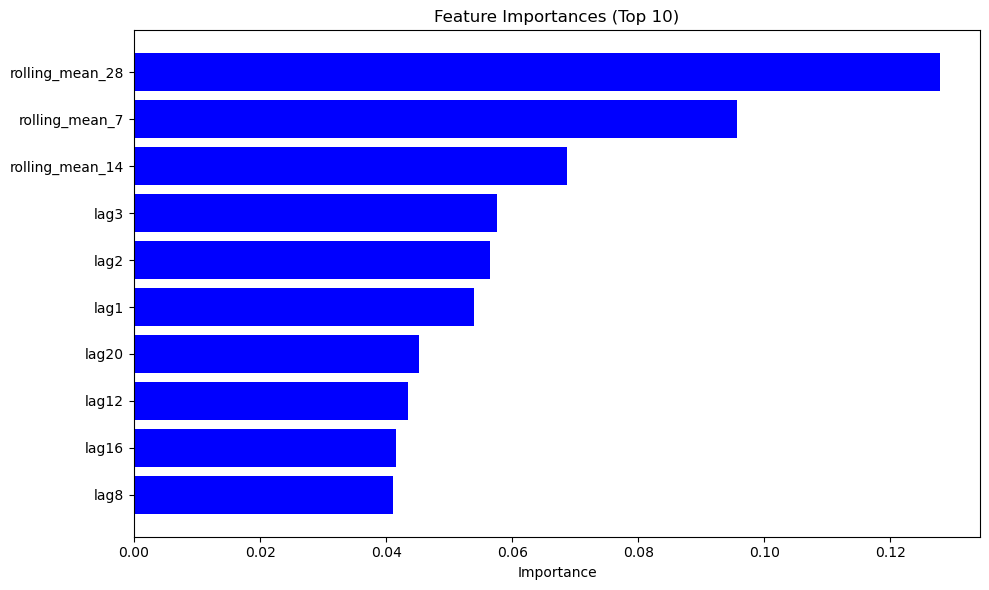

In [28]:
# Evaluate on test set
y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")

# Plot top 10 feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Top 10)")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

/Users/zaynemaughan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/zaynemaughan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/zaynemaughan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with 

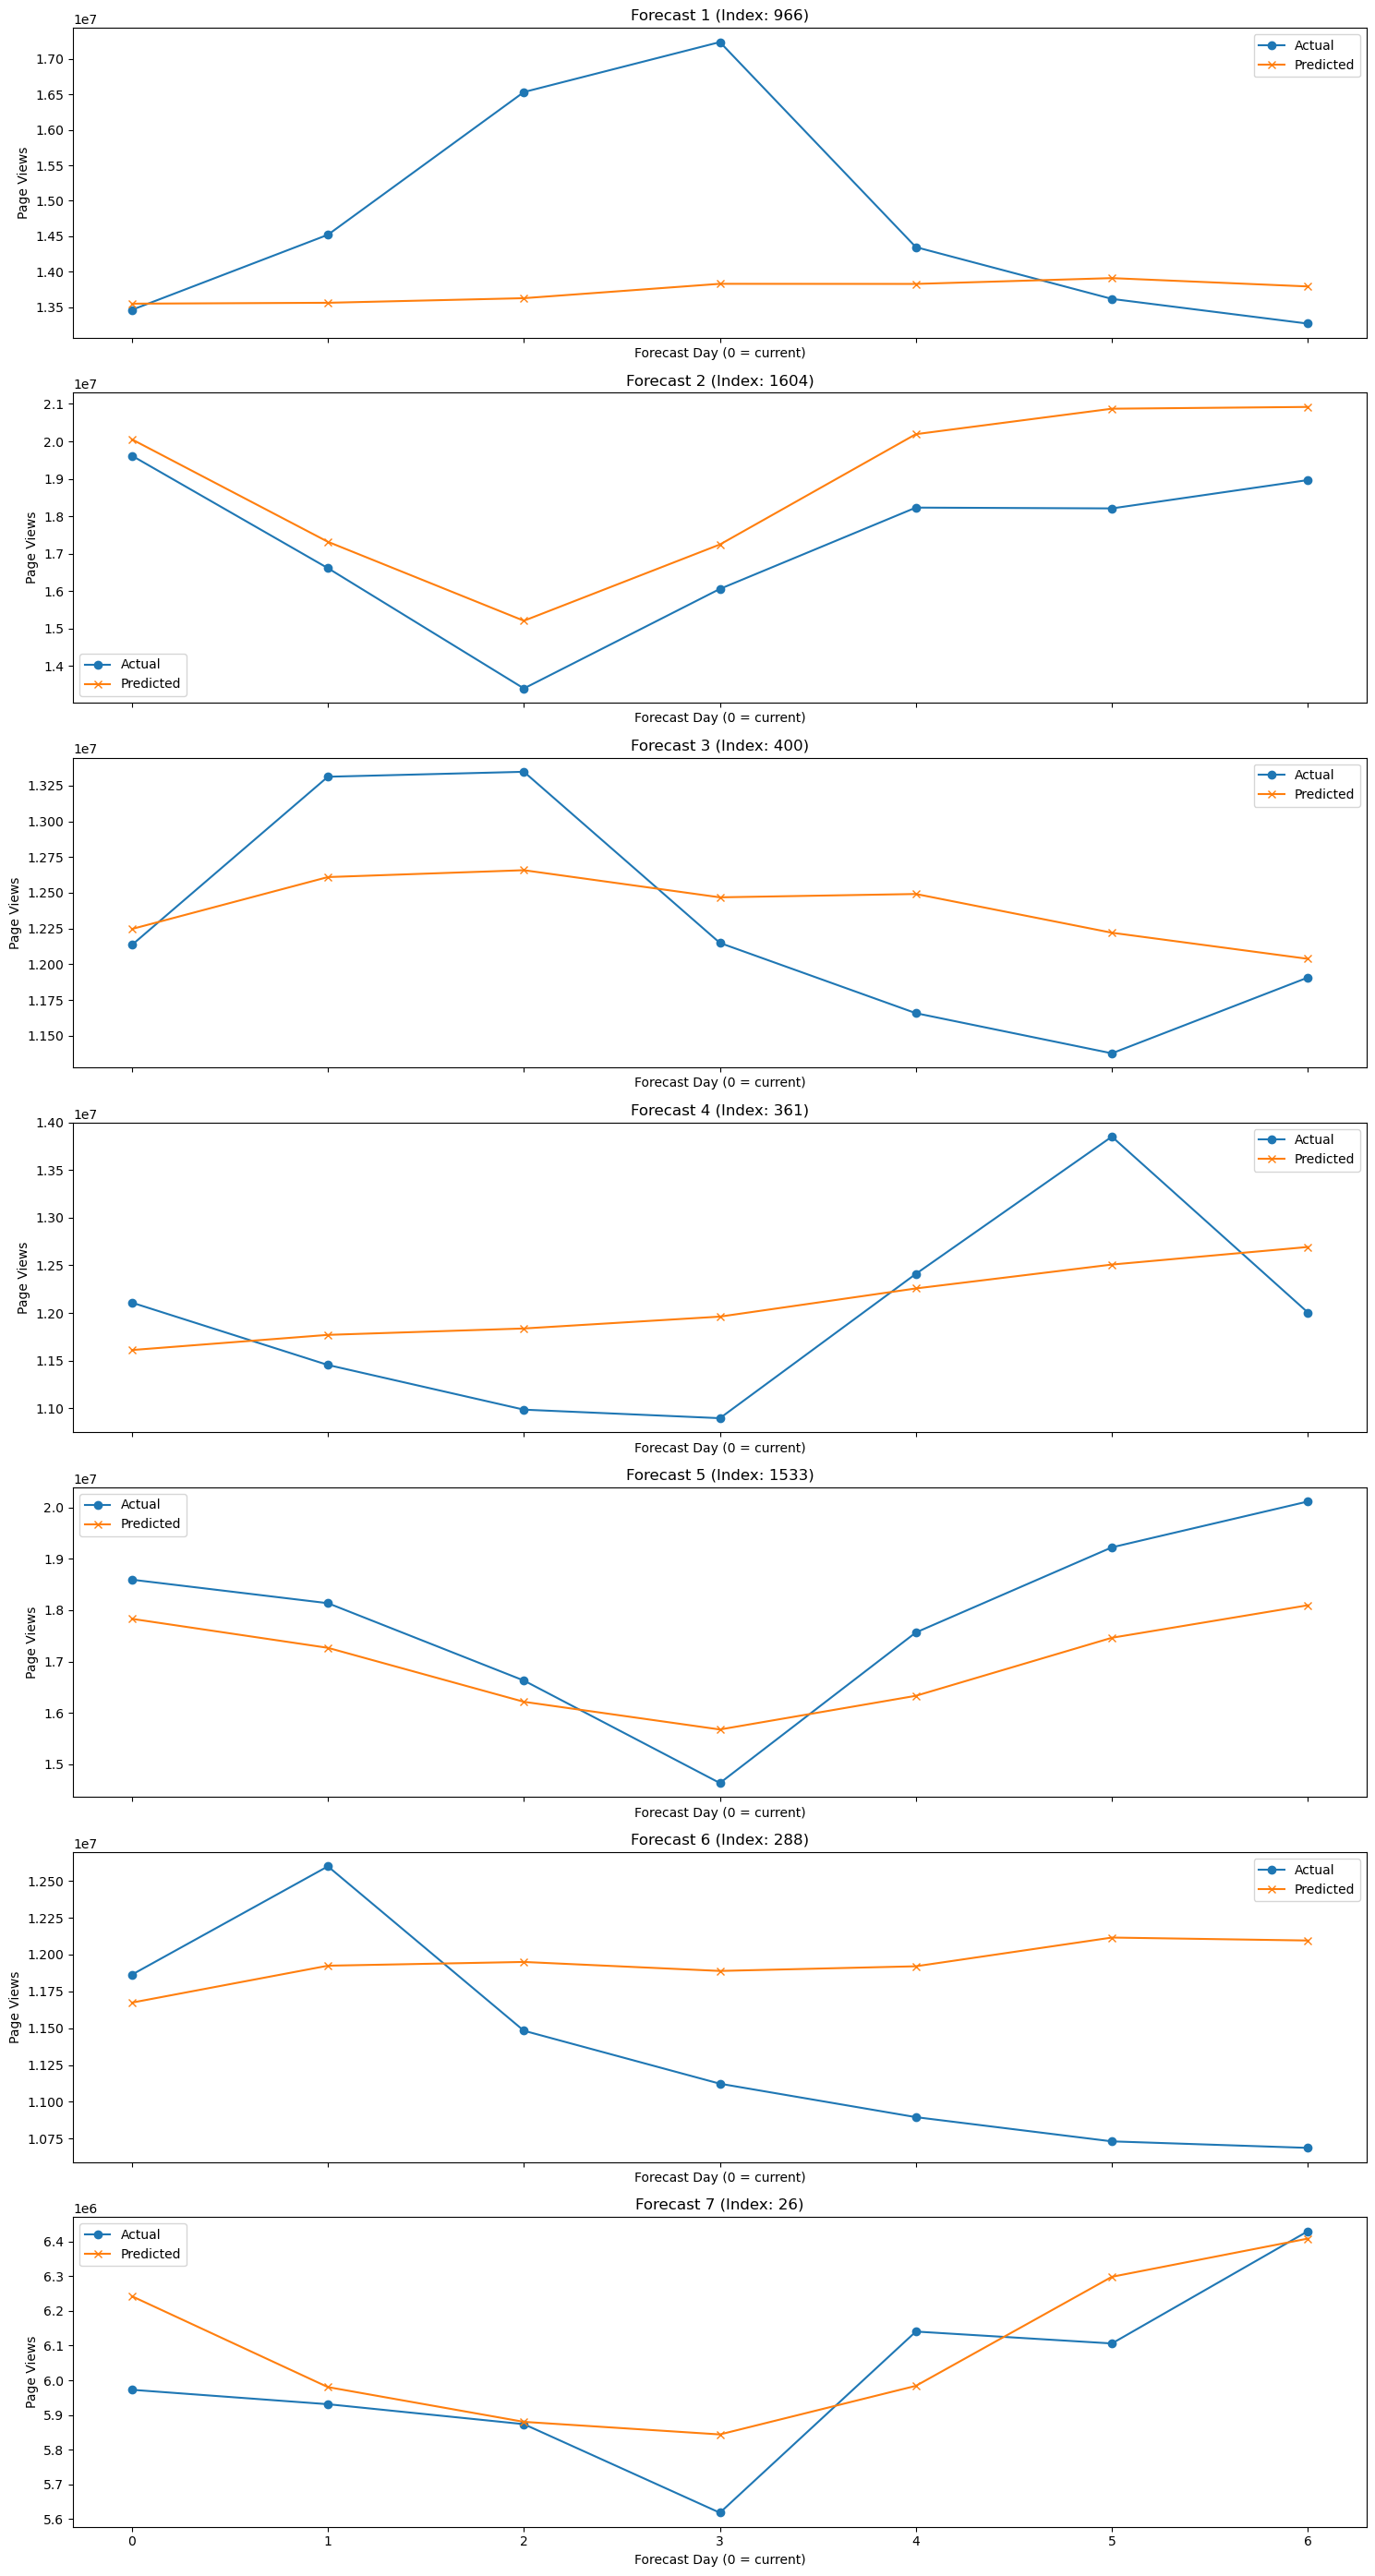

In [29]:
import random
import matplotlib.pyplot as plt

import numpy as np
# Target labels for 7-day forecast
target_labels = ['Views', 'lead1', 'lead2', 'lead3', 'lead4', 'lead5', 'lead6']
forecast_horizon = list(range(len(target_labels)))  # [0, 1, ..., 6]

# Use already scaled test data
test_df_X = X_test.copy()
test_df_y = y_test.copy()
features = test_df_X.columns.tolist()

# Pick 7 random indices from the test set
random_indices = random.sample(range(len(test_df_X)), 7)
n_plots = len(random_indices)
fig, axes = plt.subplots(n_plots, 1, figsize=(15, n_plots * 4), sharex=True)

for i, idx in enumerate(random_indices):
    # Get feature and actual target values for the selected index
    sample_features = test_df_X.iloc[idx].values.reshape(1, -1)
    scaled_actual = test_df_y.iloc[idx].values.reshape(1, -1)

    # Get predictions from the trained Random Forest model
    scaled_pred = rf.predict(sample_features)

    # Reverse scaling (if needed)
    if SCALE_TARGETS:
        unscaled_actual = scaler_target.inverse_transform(scaled_actual)
        unscaled_pred = scaler_target.inverse_transform(scaled_pred)
    else:
        unscaled_actual = scaled_actual
        unscaled_pred = scaled_pred

    # Reverse log1p (if needed)
    if DO_LOG_TRANSFORM:
        actual_final = np.expm1(unscaled_actual).flatten()
        pred_final = np.expm1(unscaled_pred).flatten()
    else:
        actual_final = unscaled_actual.flatten()
        pred_final = unscaled_pred.flatten()

    # Plotting
    ax = axes[i] if n_plots > 1 else axes
    ax.plot(forecast_horizon, actual_final, marker='o', label='Actual')
    ax.plot(forecast_horizon, pred_final, marker='x', label='Predicted')
    ax.set_title(f"Forecast {i + 1} (Index: {idx})")
    ax.set_xlabel("Forecast Day (0 = current)")
    ax.set_ylabel("Page Views")
    ax.legend()

plt.tight_layout()
plt.show()